In [39]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

from collections import defaultdict
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats import zscore
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from itertools import combinations

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import (
    StandardScaler, RobustScaler, MinMaxScaler,
    PowerTransformer, QuantileTransformer)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin

from scipy.stats import skew, kurtosis, normaltest, jarque_bera



In [2]:
df=pd.read_csv('house_price_train.csv')

In [3]:
df.shape

(1460, 81)

In [4]:
df['MSSubClass'] = df['MSSubClass'].astype(str)

## train test split and save files

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


X_train = train_df.drop(columns=['SalePrice'])
y_train = train_df['SalePrice']

X_test = test_df.drop(columns=['SalePrice'])
y_test = test_df['SalePrice']

X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [6]:
X_train= pd.read_csv("X_train.csv", dtype={'MSSubClass': str})
y_train= pd.read_csv("y_train.csv")
X_test= pd.read_csv("X_test.csv", dtype={'MSSubClass': str})
y_test= pd.read_csv("y_test.csv")

In [7]:
X_train.shape, X_test.shape

((1168, 80), (292, 80))

## identify uninformative columns

In [8]:
def identify_basic_uninformative_columns(df, threshold_null=0.8):
    df = df.copy()
    flagged_cols = {} 
    # 1 nulls
    null_ratios = df.isnull().mean()
    null_cols = null_ratios[null_ratios > threshold_null].index.tolist()
    flagged_cols['TooManyNulls'] = null_cols
    # 2 uniques
    unique_cols = [col for col in df.columns if df[col].nunique(dropna=False) == df.shape[0]]
    flagged_cols['UniqueIDColumns'] = unique_cols
    # 3 low var
    low_var_cols = [col for col in df.columns if df[col].value_counts(normalize=True, dropna=False).values[0] > 0.99]
    flagged_cols['LowVariance'] = low_var_cols

    return flagged_cols


In [9]:
flags = identify_basic_uninformative_columns(X_train)
for reason, columns in flags.items():
    if columns:
        print(f"\n {reason} ({len(columns)} column(s)):")
        for col in columns:
            print(f"   - {col}")
    else:
        print(f"\n {reason}: no column")

cols_to_drop = set(sum(flags.values(), []))
X_train_final = X_train.drop(columns=cols_to_drop)
X_test_final = X_test.drop(columns=[col for col in cols_to_drop if col in X_test.columns])
X_train_final.to_csv("X_train_final.csv", index=False)
X_test_final.to_csv("X_test_final.csv", index=False)


 TooManyNulls (4 column(s)):
   - Alley
   - PoolQC
   - Fence
   - MiscFeature

 UniqueIDColumns (1 column(s)):
   - Id

 LowVariance (5 column(s)):
   - Street
   - Utilities
   - Condition2
   - PoolArea
   - PoolQC


## outlier detection

In [10]:
X_train_final = pd.read_csv("X_train_final.csv", dtype={'MSSubClass': str})

In [11]:
def detect_outliers_by_methods(col_data):
    results = {}
    col_data = col_data.dropna()
    # z-score
    z_scores = np.abs(zscore(col_data))
    results['zscore'] = col_data.index[z_scores > 3].tolist()
    # IQR
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1
    iqr_mask = (col_data < Q1 - 1.5 * IQR) | (col_data > Q3 + 1.5 * IQR)
    results['iqr'] = col_data.index[iqr_mask].tolist()
    # Percentile
    low = col_data.quantile(0.01)
    high = col_data.quantile(0.99)
    results['percentile'] = col_data.index[(col_data < low) | (col_data > high)].tolist()
    # Modified Z-score
    median = np.median(col_data)
    mad = np.median(np.abs(col_data - median))
    if mad != 0:
        mod_z = 0.6745 * (col_data - median) / mad
        results['modified_z'] = col_data.index[np.abs(mod_z) > 3.5].tolist()
    else:
        results['modified_z'] = []
    # Isolation Forest
    try:
        iso = IsolationForest(contamination=0.01, random_state=42)
        preds = iso.fit_predict(col_data.values.reshape(-1, 1))
        results['isolation_forest'] = col_data.index[preds == -1].tolist()
    except:
        results['isolation_forest'] = []
    # LOF
    try:
        lof = LocalOutlierFactor(n_neighbors=50)
        preds = lof.fit_predict(col_data.values.reshape(-1, 1))
        results['lof'] = col_data.index[preds == -1].tolist()
    except:
        results['lof'] = []
    # DBSCAN
    try:
        scaled = StandardScaler().fit_transform(col_data.values.reshape(-1, 1))
        db = DBSCAN(eps=0.5, min_samples=5).fit(scaled)
        results['dbscan'] = col_data.index[db.labels_ == -1].tolist()
    except:
        results['dbscan'] = []

    return results


In [12]:
def outlier_comparison_table(df, numeric_cols=None):
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include='number').columns

    rows = []

    for col in numeric_cols:
        col_data = df[col].dropna()
        if col_data.nunique() < 15:
            rows.append({"Column": col, **{k: 0 for k in ['zscore','iqr','percentile','modified_z','isolation_forest','lof','dbscan']}})
            continue

        outlier_result = detect_outliers_by_methods(col_data)
        summary = {k: len(v) if isinstance(v, list) else 0 for k, v in outlier_result.items()}
        summary['Column'] = col
        rows.append(summary)

    return pd.DataFrame(rows)


In [13]:
def analyze_column_outliers(df, column, show_plot=True, show_all_indices=True, verbose=False):
    col_data = df[column].dropna()
    print(f"\n Describe for: {column}")
    print(col_data.describe())

    if show_plot:
        plt.figure(figsize=(8, 1))
        plt.boxplot(col_data, vert=False)
        plt.title(f"Boxplot of {column}")
        plt.grid(True)
        plt.show()

    outlier_indices = detect_outliers_by_methods(col_data)
    if verbose:
        print(f"\n Outlier indexes (rows) → for '{column}':")
        for method, indices in outlier_indices.items():
            print(f"  {method.upper()} ({len(indices)}): {indices if show_all_indices else indices[:10]}{'...' if len(indices) > 10 else ''}")

    return outlier_indices


In [14]:
summary_df = outlier_comparison_table(X_train_final)
print(summary_df.to_string(index=False))

 zscore  iqr  percentile  modified_z  isolation_forest  lof  dbscan        Column
     10   68          10          22                10  185       4   LotFrontage
     12   54          17          43                12   44       5       LotArea
      0    0           0           0                 0    0       0   OverallQual
      0    0           0           0                 0    0       0   OverallCond
      2    5          13           0                12   39       0     YearBuilt
      0    0           4           0                 8   49       0  YearRemodAdd
     26   77          12           0                12   36       2    MasVnrArea
      4    5          12           1                12   59       2    BsmtFinSF1
     42  131          12           0                12   24       0    BsmtFinSF2
      7   21          12           5                12   24       0     BsmtUnfSF
      8   47          12           8                12   65       5   TotalBsmtSF
      8   13    

In [15]:
summary_df.to_csv("X_train_outliers_summary.csv", index=False)


 Describe for: BsmtFinSF1
count    1168.000000
mean      446.023973
std       459.070977
min         0.000000
25%         0.000000
50%       384.500000
75%       721.000000
max      5644.000000
Name: BsmtFinSF1, dtype: float64


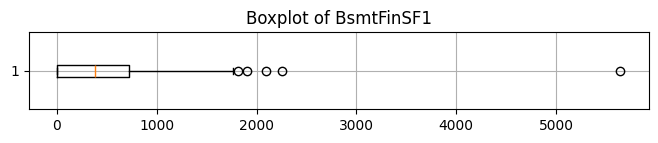

{'zscore': [173, 208, 365, 495],
 'iqr': [173, 208, 365, 495, 920],
 'percentile': [67, 123, 173, 208, 365, 388, 495, 537, 597, 664, 719, 920],
 'modified_z': [495],
 'isolation_forest': [67,
  123,
  173,
  208,
  365,
  388,
  495,
  537,
  597,
  664,
  719,
  920],
 'lof': [16,
  54,
  67,
  72,
  73,
  101,
  123,
  132,
  148,
  173,
  175,
  208,
  216,
  218,
  250,
  258,
  292,
  296,
  306,
  312,
  322,
  351,
  365,
  388,
  394,
  422,
  454,
  474,
  495,
  507,
  537,
  560,
  587,
  590,
  591,
  597,
  664,
  719,
  742,
  744,
  753,
  775,
  786,
  793,
  811,
  812,
  835,
  879,
  889,
  920,
  981,
  1046,
  1095,
  1113,
  1133,
  1147,
  1150,
  1158,
  1163],
 'dbscan': [365, 495]}

In [16]:
analyze_column_outliers(X_train_final, 'BsmtFinSF1')

In [17]:
def build_multimethod_outlier_strategy(summary_df, skew_threshold=1.0, min_methods_per_column=3):
    strategy = defaultdict(list)
    skewed_columns = []

    for _, row in summary_df.iterrows():
        col = row['Column']
        methods = ['zscore', 'iqr', 'percentile', 'modified_z', 'isolation_forest', 'lof', 'dbscan']
        selected_methods = [m for m in methods if row[m] > 0]

        if 'zscore' in selected_methods or 'modified_z' in selected_methods:
            col_data = X_train_final[col].dropna()
            if col_data.skew() > skew_threshold:
                skewed_columns.append(col)
                if 'zscore' in selected_methods:
                    selected_methods.remove('zscore')
                if 'modified_z' in selected_methods:
                    selected_methods.remove('modified_z')

        if len(selected_methods) >= min_methods_per_column:
            strategy[col] = selected_methods

    print(f"Skewed columns where zscore/modified_z were removed: {skewed_columns}")
    return strategy


def remove_outliers_multimethod_v2(df, strategy, min_methods=3, min_columns=3):
    df_cleaned = df.copy()
    total_rows_before = df.shape[0]
    method_based_outlier_indices = defaultdict(list)
    column_based_outlier_flags = defaultdict(set)

    for col, methods in strategy.items():
        col_data = df_cleaned[col].dropna()
        if col_data.nunique() < 5:
            continue

        for method in methods:
            indices = []

            if method == "zscore":
                z_scores = np.abs(zscore(col_data))
                indices = col_data.index[z_scores > 3]

            elif method == "iqr":
                Q1 = col_data.quantile(0.25)
                Q3 = col_data.quantile(0.75)
                IQR = Q3 - Q1
                mask = (col_data < Q1 - 1.5 * IQR) | (col_data > Q3 + 1.5 * IQR)
                indices = col_data.index[mask]

            elif method == "percentile":
                low = col_data.quantile(0.01)
                high = col_data.quantile(0.99)
                indices = col_data.index[(col_data < low) | (col_data > high)]

            elif method == "modified_z":
                median = np.median(col_data)
                mad = np.median(np.abs(col_data - median))
                if mad != 0:
                    mod_z = 0.6745 * (col_data - median) / mad
                    indices = col_data.index[np.abs(mod_z) > 3.5]

            elif method == "isolation_forest":
                try:
                    model = IsolationForest(contamination=0.01, random_state=42)
                    preds = model.fit_predict(col_data.values.reshape(-1, 1))
                    indices = col_data.index[preds == -1]
                except:
                    pass

            elif method == "lof":
                try:
                    model = LocalOutlierFactor(n_neighbors=50)
                    preds = model.fit_predict(col_data.values.reshape(-1, 1))
                    indices = col_data.index[preds == -1]
                except:
                    pass

            elif method == "dbscan":
                try:
                    scaled = StandardScaler().fit_transform(col_data.values.reshape(-1, 1))
                    db = DBSCAN(eps=0.5, min_samples=5).fit(scaled)
                    indices = col_data.index[db.labels_ == -1]
                except:
                    pass

            for idx in indices:
                method_based_outlier_indices[idx].append((col, method))
                column_based_outlier_flags[idx].add(col)

    strong_outliers = [idx for idx, hits in method_based_outlier_indices.items()
                       if len(hits) >= min_methods or len(column_based_outlier_flags[idx]) >= min_columns]

    df_cleaned = df_cleaned.drop(index=strong_outliers).reset_index(drop=True)
    total_rows_after = df_cleaned.shape[0]
    print(f" Outliers removed: {total_rows_before - total_rows_after} rows removed using "
          f"{min_methods}+ methods in same column or {min_columns}+ distinct columns.")

    return df_cleaned, strong_outliers


In [18]:
strategy = build_multimethod_outlier_strategy(summary_df, skew_threshold=1.0, min_methods_per_column=2)
X_train_cleaned, removed_outlier_indices = remove_outliers_multimethod_v2(X_train_final, strategy, min_methods=3, min_columns=3)
y_train_cleaned = y_train.drop(index=removed_outlier_indices).reset_index(drop=True)
X_train_cleaned = X_train_cleaned.reset_index(drop=True)

Skewed columns where zscore/modified_z were removed: ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', 'LowQualFinSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal']
 Outliers removed: 301 rows removed using 3+ methods in same column or 3+ distinct columns.



 Describe for: BsmtFinSF1
count     867.000000
mean      436.764706
std       411.116320
min         0.000000
25%         0.000000
50%       405.000000
75%       722.000000
max      1572.000000
Name: BsmtFinSF1, dtype: float64


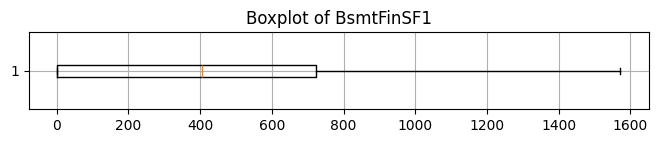

{'zscore': [],
 'iqr': [],
 'percentile': [99, 239, 318, 325, 446, 476, 504, 560, 752],
 'modified_z': [],
 'isolation_forest': [99, 239, 318, 325, 446, 476, 504, 560, 752],
 'lof': [60,
  80,
  116,
  135,
  168,
  170,
  204,
  226,
  229,
  236,
  240,
  248,
  273,
  318,
  353,
  417,
  514,
  554,
  587,
  602,
  603,
  618,
  632,
  653,
  660,
  730,
  739,
  815,
  829,
  845,
  859],
 'dbscan': []}

In [19]:
analyze_column_outliers(X_train_cleaned, 'BsmtFinSF1')

## imputation


In [20]:
print(X_train_cleaned.isnull().sum().sort_values(ascending=False))

MasVnrType       500
FireplaceQu      435
LotFrontage      159
GarageYrBlt       47
GarageCond        47
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
Length: 71, dtype: int64


In [21]:
def smart_imputation(X_train, X_test, knn_neighbors=5):
    from sklearn.impute import KNNImputer

    X_train_imputed = X_train.copy()
    X_test_imputed = X_test.copy()
    
    numeric_cols = X_train.select_dtypes(include=np.number).columns
    categorical_cols = X_train.select_dtypes(exclude=np.number).columns

    low_missing = []
    knn_missing = []
    high_missing = []

    for col in numeric_cols:
        missing_ratio = X_train[col].isnull().mean()

        if missing_ratio < 0.05:
            low_missing.append(col)
        elif missing_ratio < 0.2:
            knn_missing.append(col)
        else:
            high_missing.append(col)

    for col in low_missing:
        median_val = X_train[col].median()
        X_train_imputed[col] = X_train[col].fillna(median_val)
        X_test_imputed[col] = X_test[col].fillna(median_val)

    if knn_missing:
        knn = KNNImputer(n_neighbors=knn_neighbors)
        X_train_knn = knn.fit_transform(X_train[knn_missing])
        X_test_knn = knn.transform(X_test[knn_missing])

        X_train_imputed[knn_missing] = X_train_knn
        X_test_imputed[knn_missing] = X_test_knn

    for col in high_missing:
        X_train_imputed[col + '_missing_flag'] = X_train[col].isnull().astype(int)
        X_test_imputed[col + '_missing_flag'] = X_test[col].isnull().astype(int)
        median_val = X_train[col].median()
        X_train_imputed[col] = X_train[col].fillna(median_val)
        X_test_imputed[col] = X_test[col].fillna(median_val)

    for col in categorical_cols:
        missing_ratio = X_train[col].isnull().mean()
        if missing_ratio < 0.1:
            mode_val = X_train[col].mode()[0]
            X_train_imputed[col] = X_train[col].fillna(mode_val)
            X_test_imputed[col] = X_test[col].fillna(mode_val)
        else:
            X_train_imputed[col] = X_train[col].fillna('Missing')
            X_test_imputed[col] = X_test[col].fillna('Missing')

    return X_train_imputed, X_test_imputed


In [22]:
X_test_final = pd.read_csv("X_test_final.csv", dtype={'MSSubClass': str})

In [23]:
X_train_cleaned['MSSubClass'].dtype, X_test_final['MSSubClass'].dtype

(dtype('O'), dtype('O'))

In [24]:
X_train_final_imputed, X_test_final_imputed = smart_imputation(X_train_cleaned, X_test_final)

In [25]:
X_train_final_imputed['MSSubClass'].dtype, X_test_final_imputed['MSSubClass'].dtype

(dtype('O'), dtype('O'))

In [26]:
print(X_train_final_imputed.isnull().sum().sort_values(ascending=False))

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
LotShape         0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 71, dtype: int64


# Feature Engineering


In [27]:
class SafeFeatureEngineer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.neighborhood_quality_stats = {}
        self.saletype_stats = {}
        self.salecondition_stats = {}
        self.fitted = False
    
    def fit(self, X_train, y_train):
        
        if 'Neighborhood' in X_train.columns:
            self.neighborhood_quality_stats = X_train.groupby('Neighborhood')['OverallQual'].mean().to_dict()
            print(f" {len(self.neighborhood_quality_stats)} neighborhood statistics learned")
        
        if 'SaleType' in X_train.columns:
            self.saletype_stats = X_train.groupby('SaleType')['OverallQual'].mean().to_dict()
            print(f" {len(self.saletype_stats)} SaleType statistics learned")
        
        if 'SaleCondition' in X_train.columns:
            self.salecondition_stats = X_train.groupby('SaleCondition')['OverallQual'].mean().to_dict()
            print(f" {len(self.salecondition_stats)} SaleCondition statistics learned")
        
        self.fitted = True
        return self
    
    def transform(self, X):
        if not self.fitted:
            raise ValueError("First you need to call the fit() method.")
        
        X_fe = X.copy()
        print(f" Feature engineering is applied- Shape: {X_fe.shape}")
        
        X_fe['HouseAge'] = X_fe['YrSold'] - X_fe['YearBuilt']
        X_fe['YearsSinceRemod'] = X_fe['YrSold'] - X_fe['YearRemodAdd']
        X_fe['GarageAge'] = X_fe['YrSold'] - X_fe['GarageYrBlt']
        X_fe['IsNewHouse'] = (X_fe['HouseAge'] <= 2).astype(int)
        X_fe['IsRecentRemod'] = (X_fe['YearsSinceRemod'] <= 5).astype(int)
        
        X_fe['TotalSF'] = X_fe['1stFlrSF'] + X_fe['2ndFlrSF'] + X_fe['TotalBsmtSF']
        X_fe['TotalPorchSF'] = (X_fe['OpenPorchSF'] + X_fe['EnclosedPorch'] + 
                                X_fe['3SsnPorch'] + X_fe['ScreenPorch'])
        X_fe['TotalBathrooms'] = (X_fe['FullBath'] + X_fe['HalfBath'] * 0.5 + 
                                  X_fe['BsmtFullBath'] + X_fe['BsmtHalfBath'] * 0.5)
        
        X_fe['LivingAreaRatio'] = np.where(X_fe['TotalSF'] > 0, 
                                          X_fe['GrLivArea'] / X_fe['TotalSF'], 0)
        X_fe['LotAreaRatio'] = np.where(X_fe['LotArea'] > 0, 
                                       X_fe['GrLivArea'] / X_fe['LotArea'], 0)
        X_fe['GarageAreaRatio'] = np.where(X_fe['TotalSF'] > 0,
                                          X_fe['GarageArea'] / X_fe['TotalSF'], 0)
        
        X_fe['RoomDensity'] = np.where(X_fe['GrLivArea'] > 0, 
                                      X_fe['TotRmsAbvGrd'] / X_fe['GrLivArea'], 0)
        X_fe['BedroomRatio'] = np.where(X_fe['TotRmsAbvGrd'] > 0, 
                                       X_fe['BedroomAbvGr'] / X_fe['TotRmsAbvGrd'], 0)
        X_fe['BathBedroomRatio'] = np.where(X_fe['BedroomAbvGr'] > 0, 
                                           X_fe['TotalBathrooms'] / X_fe['BedroomAbvGr'], 0)
        
        X_fe['QualityIndex'] = X_fe['OverallQual'] * X_fe['OverallCond']
        X_fe['IsHighQuality'] = (X_fe['OverallQual'] >= 8).astype(int)
        X_fe['IsLuxury'] = ((X_fe['OverallQual'] >= 8) & (X_fe['GrLivArea'] > 2000)).astype(int)
        X_fe['IsPremium'] = ((X_fe['OverallQual'] >= 7) & (X_fe['TotalSF'] > 1800)).astype(int)
        
        X_fe['HasBasement'] = (X_fe['TotalBsmtSF'] > 0).astype(int)
        X_fe['HasGarage'] = (X_fe['GarageArea'] > 0).astype(int)
        X_fe['HasFireplace'] = (X_fe['Fireplaces'] > 0).astype(int)
        X_fe['Has2ndFloor'] = (X_fe['2ndFlrSF'] > 0).astype(int)
        X_fe['HasPorch'] = (X_fe['TotalPorchSF'] > 0).astype(int)
        X_fe['HasWoodDeck'] = (X_fe['WoodDeckSF'] > 0).astype(int)
        X_fe['HasPool'] = (X_fe['MiscVal'] > 0).astype(int)  
        X_fe['HasCentralAir'] = (X_fe['CentralAir'] == 'Y').astype(int)
        
        X_fe['IsSummerSale'] = (X_fe['MoSold'].isin([6, 7, 8])).astype(int)
        X_fe['IsWinterSale'] = (X_fe['MoSold'].isin([12, 1, 2])).astype(int)
        X_fe['IsSpringFallSale'] = (X_fe['MoSold'].isin([3, 4, 5, 9, 10, 11])).astype(int)
        X_fe['IsEndOfYear'] = (X_fe['MoSold'].isin([11, 12])).astype(int)
        
        X_fe['YearsOldWhenSold'] = X_fe['YrSold'] - X_fe['YearBuilt']
        X_fe['RemodeledBeforeSale'] = (X_fe['YearRemodAdd'] > X_fe['YearBuilt']).astype(int)

        X_fe['Quality_Size'] = X_fe['OverallQual'] * np.log1p(X_fe['GrLivArea'])
        X_fe['Age_Quality'] = X_fe['HouseAge'] * X_fe['OverallQual']
        X_fe['Neighborhood_Quality'] = X_fe['OverallQual'] * X_fe['OverallCond']
        
        log_features = ['LotArea', 'GrLivArea', 'TotalSF', 'LotFrontage', 'MasVnrArea']
        
        for feature in log_features:
            if feature in X_fe.columns:
                X_fe[f'{feature}_Log'] = np.log1p(X_fe[feature])
        
        X_fe['BsmtFinishedRatio'] = np.where(X_fe['TotalBsmtSF'] > 0,
                                            (X_fe['BsmtFinSF1'] + X_fe['BsmtFinSF2']) / X_fe['TotalBsmtSF'], 0)
        X_fe['GarageCapacityRatio'] = np.where(X_fe['GarageArea'] > 0,
                                              X_fe['GarageCars'] / (X_fe['GarageArea'] / 200), 0)
        
        X_fe = X_fe.replace([np.inf, -np.inf], np.nan)
        
        numeric_columns = X_fe.select_dtypes(include=[np.number]).columns
        X_fe[numeric_columns] = X_fe[numeric_columns].fillna(0)
        
        object_columns = X_fe.select_dtypes(include=['object']).columns
        X_fe[object_columns] = X_fe[object_columns].fillna('Unknown')
        
        print(f" Feature engineering is complete - new shape: {X_fe.shape}")
        return X_fe

def apply_feature_engineering(X_train_final_imputed, X_test_final_imputed, y_train_cleaned):

    print(" Feature Engineering Pipeline is started...")
    print(f" Train data shape: {X_train_final_imputed.shape}")
    print(f" Test data shape: {X_test_final_imputed.shape}")
    
    fe = SafeFeatureEngineer()
    
    fe.fit(X_train_final_imputed, y_train_cleaned)
    
    X_train_engineered = fe.transform(X_train_final_imputed)
    X_test_engineered = fe.transform(X_test_final_imputed)
    
    print(f" Original feature count: {X_train_final_imputed.shape[1]}")
    print(f" New feature count: {X_train_engineered.shape[1]}")
    print(f" The number of features added: {X_train_engineered.shape[1] - X_train_final_imputed.shape[1]}")
    
    return X_train_engineered, X_test_engineered

def validate_feature_engineering(X_train_original, X_test_original, X_train_fe, X_test_fe):

    print("\n FEATURE ENGİNEERİNG validation:")
    
    print(f"Train shape: {X_train_original.shape} → {X_train_fe.shape}")
    print(f"Test shape: {X_test_original.shape} → {X_test_fe.shape}")
    
    if X_train_fe.shape[1] != X_test_fe.shape[1]:
        print(" The number of columns in the train and test data is different!")
    else:
        print(" The number of columns in the train and test data is the same.")
    
    train_cols = set(X_train_fe.columns)
    test_cols = set(X_test_fe.columns)
    
    if train_cols != test_cols:
        print(" The column names in the train and test data are different!")
        print(f" In Train but not in Test: {train_cols - test_cols}")
        print(f" In test but not in train: {test_cols - train_cols}")
    else:
        print(" The column names in the train and test data are the same.")
    
    train_nan_count = X_train_fe.isna().sum().sum()
    test_nan_count = X_test_fe.isna().sum().sum()
    
    train_inf_count = np.isinf(X_train_fe.select_dtypes(include=[np.number])).sum().sum()
    test_inf_count = np.isinf(X_test_fe.select_dtypes(include=[np.number])).sum().sum()
    
    print(f"NaN count - Train: {train_nan_count}, Test: {test_nan_count}")
    print(f"Inf count - Train: {train_inf_count}, Test: {test_inf_count}")
    
    print(" Feature engineering validation is completed !\n")


In [28]:
X_train_engineered, X_test_engineered = apply_feature_engineering(
    X_train_final_imputed, 
    X_test_final_imputed, 
    y_train_cleaned
)

validate_feature_engineering(
    X_train_final_imputed, 
    X_test_final_imputed,
    X_train_engineered, 
    X_test_engineered
)

 Feature Engineering Pipeline is started...
 Train data shape: (867, 71)
 Test data shape: (292, 71)
 24 neighborhood statistics learned
 9 SaleType statistics learned
 6 SaleCondition statistics learned
 Feature engineering is applied- Shape: (867, 71)
 Feature engineering is complete - new shape: (867, 113)
 Feature engineering is applied- Shape: (292, 71)
 Feature engineering is complete - new shape: (292, 113)
 Original feature count: 71
 New feature count: 113
 The number of features added: 42

 FEATURE ENGİNEERİNG validation:
Train shape: (867, 71) → (867, 113)
Test shape: (292, 71) → (292, 113)
 The number of columns in the train and test data is the same.
 The column names in the train and test data are the same.
NaN count - Train: 0, Test: 0
Inf count - Train: 0, Test: 0
 Feature engineering validation is completed !



## encoding 

In [29]:
def encode_house_price_data(X_train, X_test, y_train):
    X_train_enc = X_train.copy()
    X_test_enc = X_test.copy()

    # ----- ORDINAL ENCODING -----
    ordinal_mappings = {
        'MSZoning':       ['C (all)', 'RH', 'RM', 'RL', 'FV'],
        'LandContour':    ['Low', 'Bnk', 'HLS', 'Lvl'],
        'Electrical':     ['FuseP', 'FuseF', 'FuseA', 'SBrkr'],
        'MasVnrType':     ['Missing', 'BrkCmn', 'BrkFace', 'Stone'],
        'RoofMatl':       ['Roll', 'Tar&Grv', 'CompShg', 'WdShngl', 'WdShake', 'Metal'],
        'HouseStyle':     ['SFoyer', 'SLvl', '1.5Unf', '1Story', '1.5Fin', '2.5Unf', '2Story', '2.5Fin'],
        'ExterQual':      ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'ExterCond':      ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'BsmtQual':       ['Fa', 'TA', 'Gd', 'Ex'],
        'BsmtCond':       ['Po', 'Fa', 'TA', 'Gd'],
        'BsmtExposure':   ['No', 'Mn', 'Av', 'Gd'],
        'BsmtFinType1':   ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
        'BsmtFinType2':   ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
        'HeatingQC':      ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'KitchenQual':    ['Fa', 'TA', 'Gd', 'Ex'],
        'Functional':     ['Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
        'FireplaceQu':    ['Missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'GarageFinish':   ['Unf', 'RFn', 'Fin'],
        'GarageQual':     ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'GarageCond':     ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
        'PavedDrive':     ['N', 'P', 'Y'],
        'LotShape':       ['IR3', 'IR2', 'IR1', 'Reg'],
        'LandSlope':      ['Sev', 'Mod', 'Gtl']
    }

    for col, order in ordinal_mappings.items():
        if col in X_train_enc.columns:
            mapping = {k: v for v, k in enumerate(order)}
            X_train_enc[col] = X_train_enc[col].map(mapping)
            X_test_enc[col] = X_test_enc[col].map(mapping).fillna(-1)

    # ----- BINARY ENCODING -----
    if 'CentralAir' in X_train_enc.columns:
        X_train_enc['CentralAir'] = X_train_enc['CentralAir'].map({'N': 0, 'Y': 1})
        X_test_enc['CentralAir'] = X_test_enc['CentralAir'].map({'N': 0, 'Y': 1})

    # ----- ONE-HOT ENCODING -----
    onehot_cols = [
        'MSSubClass', 'LotConfig', 'BldgType', 'RoofStyle', 'Exterior1st',
        'Exterior2nd', 'Condition1', 'Foundation', 'Heating', 'GarageType'
    ]
    
    onehot_cols = [col for col in onehot_cols if col in X_train_enc.columns]
    
    if onehot_cols:
        X_train_enc = pd.get_dummies(X_train_enc, columns=onehot_cols, drop_first=True, dtype=int)
        X_test_enc = pd.get_dummies(X_test_enc, columns=onehot_cols, drop_first=True, dtype=int)
        X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

    # ----- NEIGHBORHOOD: TARGET ENCODING -----
    if 'Neighborhood' in X_train.columns:
        # Simple and robust approach
        smoothing = 10
        global_median = y_train.median()
        
        X_train_neighborhood = X_train['Neighborhood'].fillna('Unknown')
        X_test_neighborhood = X_test['Neighborhood'].fillna('Unknown')
        
        neighborhood_encoded = np.full(len(X_train), global_median)
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        for train_idx, val_idx in kf.split(X_train):
            X_tr_neigh = X_train_neighborhood.iloc[train_idx]
            X_val_neigh = X_train_neighborhood.iloc[val_idx]
            y_tr = y_train.iloc[train_idx]
            
            neigh_medians = {}
            for neigh in X_tr_neigh.unique():
                mask = X_tr_neigh == neigh
                if mask.sum() > 0:
                    neigh_prices = y_tr[mask]
                    median_price = neigh_prices.median()
                    count = len(neigh_prices)
                    smoothed_price = (median_price * count + global_median * smoothing) / (count + smoothing)
                    neigh_medians[neigh] = smoothed_price
                else:
                    neigh_medians[neigh] = global_median
            
            for i, val_idx_i in enumerate(val_idx):
                neigh = X_val_neigh.iloc[i]
                neighborhood_encoded[val_idx_i] = neigh_medians.get(neigh, global_median)
        
        X_train_enc['Neighborhood_TE'] = neighborhood_encoded
        
        neigh_medians_test = {}
        for neigh in X_train_neighborhood.unique():
            mask = X_train_neighborhood == neigh
            if mask.sum() > 0:
                neigh_prices = y_train[mask]
                median_price = neigh_prices.median()
                count = len(neigh_prices)
                smoothed_price = (median_price * count + global_median * smoothing) / (count + smoothing)
                neigh_medians_test[neigh] = smoothed_price
            else:
                neigh_medians_test[neigh] = global_median
        
        X_test_enc['Neighborhood_TE'] = X_test_neighborhood.map(neigh_medians_test)
        X_test_enc['Neighborhood_TE'].fillna(global_median, inplace=True)
        
        X_train_enc.drop('Neighborhood', axis=1, inplace=True)
        X_test_enc.drop('Neighborhood', axis=1, inplace=True)

    # ----- SALETYPE, SALECONDITION: FREQUENCY ENCODING -----
    freq_cols = ['SaleType', 'SaleCondition']
    for col in freq_cols:
        if col in X_train.columns:
            freqs = X_train[col].value_counts(normalize=True)
            min_freq = freqs.min() if len(freqs) > 0 else 0.001
            
            X_train_enc[col] = X_train[col].map(freqs)
            X_test_enc[col] = X_test[col].map(freqs).fillna(min_freq)

    X_train_enc.fillna(0, inplace=True)
    X_test_enc.fillna(0, inplace=True)

    return X_train_enc, X_test_enc

In [30]:
X_train_encoded, X_test_encoded = encode_house_price_data(
    X_train_final_imputed, X_test_final_imputed, y_train_cleaned
)

print(f"Training set shape: {X_train_encoded.shape}")
print(f"Test set shape: {X_test_encoded.shape}")
print(f"Columns match: {list(X_train_encoded.columns) == list(X_test_encoded.columns)}")

if 'Neighborhood_TE' in X_train_encoded.columns:
    print(f"\nNeighborhood_TE stats:")
    print(f"Train: {X_train_encoded['Neighborhood_TE'].describe()}")
    print(f"Test: {X_test_encoded['Neighborhood_TE'].describe()}")

print(f"\nMissing values in training: {X_train_encoded.isnull().sum().sum()}")
print(f"Missing values in test: {X_test_encoded.isnull().sum().sum()}")

Training set shape: (867, 134)
Test set shape: (292, 134)
Columns match: True

Neighborhood_TE stats:
Train: count       867.000000
mean     167582.638782
std       34678.873981
min      124344.827586
25%      141035.398230
50%      167684.210526
75%      193902.127660
max      257666.666667
Name: Neighborhood_TE, dtype: float64
Test: count                                           292
unique                                           25
top       SalePrice    141496.598639
dtype: float64
freq                                             44
Name: Neighborhood_TE, dtype: object

Missing values in training: 0
Missing values in test: 0


## scaling

<Axes: >

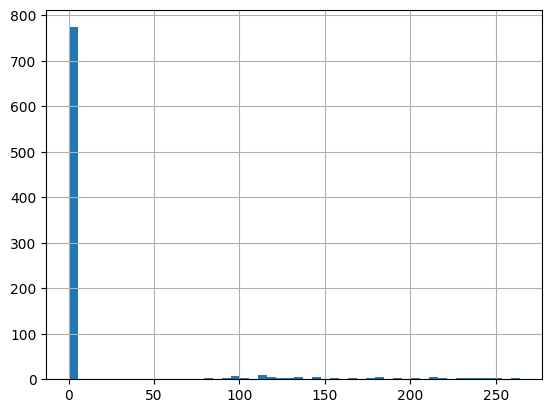

In [31]:
X_train_encoded['EnclosedPorch'].hist(bins=50)


In [32]:
def find_sparse_columns(df: pd.DataFrame, threshold: float = 0.95) -> list:
    sparse_cols = []
    row_count = len(df)
    for col in df.select_dtypes(include=[np.number]).columns:
        zero_ratio = (df[col] == 0).sum() / row_count
        if zero_ratio >= threshold:
            sparse_cols.append(col)
    return sparse_cols

def analyze_sparse_columns(df: pd.DataFrame, y: pd.Series, threshold: float = 0.95):
    sparse_cols = find_sparse_columns(df, threshold)
    print(f"Sparse columns (threshold={threshold}): {len(sparse_cols)} of {len(df.columns)}")
    original_features = []
    one_hot_features = []
    for col in sparse_cols:
        if '_' in col:
            one_hot_features.append(col)
        else:
            original_features.append(col)
    print(f"  Original sparse: {len(original_features)}")
    print(f"  One-hot sparse: {len(one_hot_features)}")
    return original_features, one_hot_features

def handle_sparse_columns_importance(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series,
                                     threshold: float = 0.95,
                                     conservative_threshold: float = 0.98):
    original_features, one_hot_features = analyze_sparse_columns(X_train, y_train, threshold)

    X_train_processed = X_train.copy()
    X_test_processed = X_test.copy()
    removed_cols = []

    if len(original_features) > 0:
        print("\nChecking importance for original sparse columns...")
        X_sparse = X_train[original_features]
        rf = RandomForestRegressor(n_estimators=50, random_state=42)
        rf.fit(X_sparse, y_train)
        importance = pd.DataFrame({
            'feature': original_features,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        top_n = max(5, int(len(original_features) * 0.2))
        important_original = importance.head(top_n)['feature'].tolist()
        print(f"  Kept: {len(important_original)} original sparse")
        removed_original = [col for col in original_features if col not in important_original]
    else:
        removed_original = []

    very_sparse_onehot = []
    for col in one_hot_features:
        zero_ratio = (X_train[col] == 0).sum() / len(X_train)
        if zero_ratio >= conservative_threshold:
            very_sparse_onehot.append(col)
    print(f"  Removed: {len(very_sparse_onehot)} very sparse one-hot")

    removed_cols = removed_original + very_sparse_onehot
    X_train_processed = X_train_processed.drop(columns=removed_cols)
    X_test_processed = X_test_processed.drop(columns=removed_cols)

    print(f"\nResult:")
    print(f"  Removed columns: {len(removed_cols)}")
    print(f"  Remaining columns: {X_train_processed.shape[1]}")

    return X_train_processed, X_test_processed, removed_cols


In [33]:
X_train_del_sparse, X_test_del_sparse, removed_cols = handle_sparse_columns_importance(
    X_train_encoded,
    X_test_encoded,
    y_train_cleaned,
    threshold=0.80,
    conservative_threshold=0.99
)


Sparse columns (threshold=0.8): 70 of 134
  Original sparse: 8
  One-hot sparse: 62

Checking importance for original sparse columns...
  Kept: 5 original sparse
  Removed: 27 very sparse one-hot

Result:
  Removed columns: 30
  Remaining columns: 104


In [34]:
X_train_del_sparse.shape

(867, 104)

In [37]:
def determine_optimal_scaling(df: pd.DataFrame, 
                            skew_threshold=1.0,
                            kurtosis_threshold=3.0,
                            outlier_threshold=0.15,
                            extreme_outlier_threshold=0.05,
                            scale_factor_threshold=10.0,
                            verbose=False) -> dict:
    scaling_dict = {}
    column_stats = {}
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        col_data = df[col].dropna()
        if len(col_data) == 0:
            scaling_dict[col] = 'none'
            continue
        
        stats = analyze_column_distribution(col_data, verbose=False)
        column_stats[col] = stats
        scaling_method = decide_scaling_method(stats, 
                                               skew_threshold,
                                               kurtosis_threshold,
                                               outlier_threshold,
                                               extreme_outlier_threshold,
                                               scale_factor_threshold,
                                               verbose=False)
        scaling_dict[col] = scaling_method
    return scaling_dict, column_stats

def analyze_column_distribution(column_data, verbose=False):
    from scipy.stats import skew, kurtosis
    stats = {
        "mean": column_data.mean(),
        "std": column_data.std(),
        "min": column_data.min(),
        "max": column_data.max(),
        "skewness": skew(column_data),
        "kurtosis": kurtosis(column_data),
        "outliers": ((column_data - column_data.mean()).abs() > 3 * column_data.std()).sum() / len(column_data),
        "extreme_outliers": ((column_data - column_data.mean()).abs() > 5 * column_data.std()).sum() / len(column_data),
        "scale_factor": column_data.max() / (abs(column_data.min()) + 1e-9)  # avoid division by 0
    }
    if verbose:
        print(f"Stats for column:\n{stats}")
    return stats
    
def decide_scaling_method(stats,
                          skew_threshold,
                          kurtosis_threshold,
                          outlier_threshold,
                          extreme_outlier_threshold,
                          scale_factor_threshold,
                          verbose=False):
    skewness = abs(stats['skewness'])
    kurt = abs(stats['kurtosis'])
    outliers = stats['outliers']
    extreme_outliers = stats['extreme_outliers']
    scale_factor = stats['scale_factor']

    if verbose:
        print(f"Evaluating scaling method - skew: {skewness}, kurt: {kurt}, outliers: {outliers}, extreme: {extreme_outliers}, scale: {scale_factor}")

    if extreme_outliers > extreme_outlier_threshold:
        return 'robust'
    elif outliers > outlier_threshold:
        return 'power'
    elif skewness > skew_threshold or kurt > kurtosis_threshold:
        return 'quantile'
    elif scale_factor > scale_factor_threshold:
        return 'minmax'
    elif skewness > 1.5:
        return 'log_standard'
    else:
        return 'standard'

def apply_advanced_scaling(X_train, X_test, scaling_dict, column_stats=None):
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    scalers = {}
    
    grouped_scaling = defaultdict(list)
    for col, method in scaling_dict.items():
        if col in X_train.columns:
            grouped_scaling[method].append(col)
    
    if 'standard' in grouped_scaling:
        scaler = StandardScaler()
        cols = grouped_scaling['standard']
        X_train_scaled[cols] = scaler.fit_transform(X_train[cols])
        X_test_scaled[cols] = scaler.transform(X_test[cols])
        scalers['standard'] = scaler
    
    if 'robust' in grouped_scaling:
        scaler = RobustScaler()
        cols = grouped_scaling['robust']
        X_train_scaled[cols] = scaler.fit_transform(X_train[cols])
        X_test_scaled[cols] = scaler.transform(X_test[cols])
        scalers['robust'] = scaler
    
    if 'minmax' in grouped_scaling:
        scaler = MinMaxScaler()
        cols = grouped_scaling['minmax']
        X_train_scaled[cols] = scaler.fit_transform(X_train[cols])
        X_test_scaled[cols] = scaler.transform(X_test[cols])
        scalers['minmax'] = scaler
    
    if 'power' in grouped_scaling:
        scaler = PowerTransformer(method='yeo-johnson', standardize=True)
        cols = grouped_scaling['power']
        X_train_scaled[cols] = scaler.fit_transform(X_train[cols])
        X_test_scaled[cols] = scaler.transform(X_test[cols])
        scalers['power'] = scaler
    
    if 'quantile' in grouped_scaling:
        scaler = QuantileTransformer(output_distribution='normal', random_state=42)
        cols = grouped_scaling['quantile']
        X_train_scaled[cols] = scaler.fit_transform(X_train[cols])
        X_test_scaled[cols] = scaler.transform(X_test[cols])
        scalers['quantile'] = scaler
    
    if 'log_standard' in grouped_scaling:
        cols = grouped_scaling['log_standard']
        X_train_log = np.log1p(X_train[cols])
        X_test_log = np.log1p(X_test[cols])
        scaler = StandardScaler()
        X_train_scaled[cols] = scaler.fit_transform(X_train_log)
        X_test_scaled[cols] = scaler.transform(X_test_log)
        scalers['log_standard'] = scaler
    
    return X_train_scaled, X_test_scaled, scalers


def prepare_data_for_linear_regression(X_train, X_test, verbose=False):
    scaling_dict, column_stats = determine_optimal_scaling(
        X_train, verbose=False
    )
    
    X_train_scaled, X_test_scaled, scalers = apply_advanced_scaling(
        X_train, X_test, scaling_dict, column_stats
    )
    
    return X_train_scaled, X_test_scaled, scalers, scaling_dict


In [40]:
X_train_scaled, X_test_scaled, scalers, scaling_dict = prepare_data_for_linear_regression(
    X_train_del_sparse, X_test_del_sparse, verbose=True  )


<Axes: >

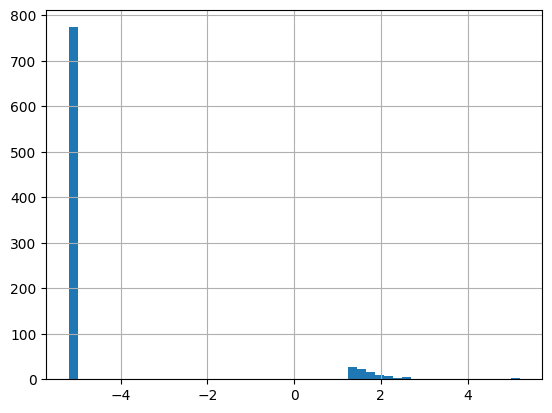

In [41]:
X_train_scaled['EnclosedPorch'].hist(bins=50)

In [42]:
def identify_structural_redundant_columns(X, y, corr_thresh=0.1, multicol_thresh=0.85):
    """
    X: features (DataFrame)
    y: target (Series or single-column DataFrame)
    """
    flagged_cols = {}
    numeric_cols = X.select_dtypes(include=np.number).copy()

    if isinstance(y, pd.DataFrame):
        y = y.squeeze()
    y_array = y.fillna(0).values

    try:
        correlations = numeric_cols.apply(
            lambda col: np.corrcoef(col.fillna(0).values, y_array)[0, 1]
        )
        correlations = correlations.abs()
        low_corr_cols = correlations[correlations < corr_thresh].index.tolist()
        flagged_cols['LowCorrelation'] = low_corr_cols
    except Exception:
        flagged_cols['LowCorrelation'] = []

    redundant_combinations = []
    to_drop_redundant = []

    valid_cols = [
        col for col in numeric_cols.columns
        if X[col].nunique() >= 5 and (X[col] == 0).mean() <= 0.8
    ]

    for col1, col2 in combinations(valid_cols, 2):
        sum_series = X[col1].fillna(0) + X[col2].fillna(0)
        for col3 in valid_cols:
            if col3 in (col1, col2):
                continue
            target_series = X[col3].fillna(0)
            match_ratio = np.isclose(sum_series, target_series, rtol=0.01, atol=1).mean()
            if match_ratio > 0.98 and sum_series.std() > 10 and target_series.std() > 10:
                redundant_combinations.append((col1, col2, col3))
                to_drop_redundant.append(col3)

    redundant_components = set()
    redundant_targets = set()
    for col1, col2, col3 in redundant_combinations:
        redundant_components.update([col1, col2])
        redundant_targets.add(col3)

    flagged_cols['RedundantToDrop'] = list(set(to_drop_redundant))

    high_corr_pairs = []
    to_drop_multicol = []

    if numeric_cols.shape[1] > 1:
        corr_matrix = numeric_cols.corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        corr_with_target = numeric_cols.apply(
            lambda col: np.corrcoef(col.fillna(0).values, y_array)[0, 1]
        ).abs()

        for col in upper_tri.columns:
            for row in upper_tri.index:
                if (row in redundant_components and col in redundant_targets) or \
                   (col in redundant_components and row in redundant_targets):
                    continue
                corr_val = upper_tri.loc[row, col]
                if pd.notnull(corr_val) and corr_val > multicol_thresh:
                    high_corr_pairs.append((row, col))
                    if corr_with_target.get(row, 0) < corr_with_target.get(col, 0):
                        to_drop_multicol.append(row)
                    else:
                        to_drop_multicol.append(col)

    to_drop_multicol = [col for col in to_drop_multicol if col not in redundant_components]
    flagged_cols['MulticollinearityToDrop'] = list(set(to_drop_multicol))

    return flagged_cols


In [43]:
flags = identify_structural_redundant_columns(X_train_scaled, y_train_cleaned)

cols_to_drop = list(set(
    flags['LowCorrelation'] +
    flags['RedundantToDrop'] +
    flags['MulticollinearityToDrop']
))

X_train_cleaned_final = X_train_scaled.drop(columns=cols_to_drop)
X_test_cleaned_final = X_test_scaled.drop(columns=cols_to_drop)


In [44]:
for reason, columns in flags.items():
    print(f"\n--- {reason} ---")
    print(f"columns count: {len(columns)}")
    print("columns:", columns)




--- LowCorrelation ---
columns count: 30
columns: ['LandContour', 'LandSlope', 'RoofMatl', 'ExterCond', 'BsmtHalfBath', 'GarageCond', 'ScreenPorch', 'MoSold', 'YrSold', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_70', 'MSSubClass_80', 'MSSubClass_85', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_Inside', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'RoofStyle_Gable', 'Exterior1st_BrkFace', 'Exterior1st_Plywood', 'Exterior1st_Stucco', 'Exterior1st_WdShing', 'Exterior2nd_HdBoard', 'Exterior2nd_Plywood', 'Exterior2nd_Stucco', 'Exterior2nd_Wd Shng', 'Condition1_RRAe', 'Condition1_RRAn']

--- RedundantToDrop ---
columns count: 0
columns: []

--- MulticollinearityToDrop ---
columns count: 12
columns: ['MasVnrArea', 'BsmtFinType2', 'Exterior2nd_MetalSd', 'RoofStyle_Gable', 'Exterior2nd_Wd Sdng', 'Fireplaces', 'Exterior2nd_HdBoard', 'MSSubClass_190', 'Exterior2nd_VinylSd', 'Exterior1st_CemntBd', 'GarageArea', 'BldgType_Duplex']


In [45]:
X_train_scaled.shape

(867, 104)

In [46]:
X_train_cleaned_final.shape

(867, 64)

## model qurulmasi ve metric-lere baxilmasi

In [47]:
X_train = X_train_cleaned_final
X_test = X_test_cleaned_final
y_train = y_train_cleaned.values.ravel()  # .ravel() array etmək üçün
y_test = pd.read_csv("y_test.csv").values.ravel()


In [48]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)  # sadəcə R² müqayisəsi üçün (opsional)

model = LinearRegression()
model.fit(X_train, y_train_log)

y_pred_train_log = model.predict(X_train)
y_pred_test_log = model.predict(X_test)

y_pred_train = np.expm1(y_pred_train_log)
y_pred_test = np.expm1(y_pred_test_log)

print(" Train Set:")
print(f"  R² Score:  {r2_score(y_train, y_pred_train):.4f}")
print(f"  MAE:       {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"  MSE:       {mean_squared_error(y_train, y_pred_train):.2f}")

print("\n Test Set:")
print(f"  R² Score:  {r2_score(y_test, y_pred_test):.4f}")
print(f"  MAE:       {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"  MSE:       {mean_squared_error(y_test, y_pred_test):.2f}")

 Train Set:
  R² Score:  0.9267
  MAE:       11773.89
  MSE:       282371805.59

 Test Set:
  R² Score:  0.9260
  MAE:       15540.99
  MSE:       567488258.88
